In [1]:
from dask.distributed import Client, progress
from dask import dataframe as dd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# enable matplotlib to display inline
%matplotlib inline

In [2]:
client = Client('10.10.100.15:8786')

In [3]:
client

<Client: scheduler='tcp://10.10.100.15:8786' processes=18 cores=18>

In [4]:
# create the dataframe by reading in the all the CSVs
csv = '/root/yellow_tripdata_2015-*'

# load the csv file into a dask dataframe
df = dd.read_csv(csv, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df = client.persist(df)
progress(df)

In [5]:
# how many yellow cab trips were recorded in 2015?
len(df)

134652416

In [6]:
# look at the first few rows
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [7]:
# and the list of columns
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [8]:
# how do the trip distances vary as a function of the number of passengers?
df.groupby(df.passenger_count).trip_distance.mean().compute()

passenger_count
0     2.279150
1    16.329340
2    12.566690
3     1.490711
4     7.890089
5     3.066537
6     2.975129
9     5.419161
7     3.193364
8     4.043393
Name: trip_distance, dtype: float64

In [9]:
# compute average tip, as a fraction of the fare amount, and explore how that fraction varies as a function of 
#   i) the hour of the day and 
#  ii) the day of the week.

# first, remove nonsense rows
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]

# create a tip_fraction column
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount  

In [10]:
# since we have datetime objects, we can use the new `dt.weekday_name` and `dt.hour` conveience 
# converters.
# we'll use the pick up date for these calculations:
dayofweek = (df2.groupby(df2.tpep_pickup_datetime.dt.weekday_name).tip_fraction.mean())
hour      = (df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean())

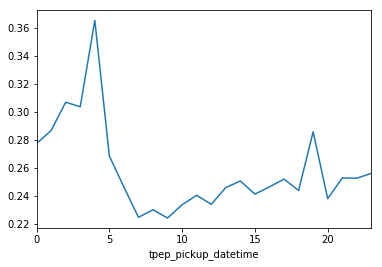

In [11]:
# there are 24 hours in a day so we can just grab all values and plot like this:
hour.head(24).plot()

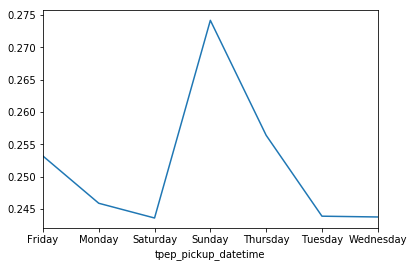

In [12]:
# similarly for day of the week
dayofweek.head(7).plot()

In [15]:
# create a new column that has the payment name included in it. 
# since the payment_type is an integer code,
# we first create a simple dictionary with the mapping rule:
payment_types = {1: 'Credit Card', 
                         2: 'Cash', 
                         3: 'No Charge', 
                         4: 'Dispute', 
                         5: 'Unknown', 
                         6: 'Voided trip'}

# now just use the `map()` method to create the new column
df['payment_name'] = df['payment_type'].map(payment_types)

In [16]:
# now, analyze how the tip amount average changes with payment type
df.groupby(df.payment_name).tip_amount.mean().compute()

payment_name
Cash           0.000222
Credit Card    2.755587
Dispute       -0.012641
No Charge      0.004536
Unknown        0.080000
Name: tip_amount, dtype: float64

In [19]:
# by setting an index on a column, we pay an upfront cost, but then subsequent ordered lookups are much faster:
df3 = client.persist(df.set_index('tpep_pickup_datetime'))

In [21]:
# for each month, we look at the first records from the first day. for example, for jan:
df3.loc['2015-01-01'].head(10)

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_name
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2,2015-01-01 00:00:00,1,1.68,-73.991547,40.750069,1,N,0.000000,0.000000,2,10.0,0.0,0.5,0.0,0.0,0.3,10.8,Cash
2015-01-01 00:00:00,2,2015-01-01 00:00:00,3,1.56,-74.001320,40.729057,1,N,-74.010208,40.719662,1,7.5,0.5,0.5,0.0,0.0,0.3,8.8,Credit Card
2015-01-01 00:00:00,1,2015-01-01 00:11:26,5,4.00,-73.971436,40.760201,1,N,-73.921181,40.768269,2,13.5,0.5,0.5,0.0,0.0,0.0,14.5,Cash
2015-01-01 00:00:01,1,2015-01-01 00:03:49,1,0.80,-73.860847,40.757294,1,N,-73.868111,40.752285,2,5.0,0.5,0.5,0.0,0.0,0.0,6.3,Cash
2015-01-01 00:00:03,2,2015-01-01 00:21:48,2,2.57,-73.969017,40.754269,1,N,-73.994133,40.761600,2,14.5,0.5,0.5,0.0,0.0,0.3,15.8,Cash
2015-01-01 00:00:03,2,2015-01-01 00:10:50,1,1.58,-73.987579,40.765270,1,N,-73.976921,40.776970,1,9.0,0.5,0.5,1.9,0.0,0.3,12.2,Credit Card
2015-01-01 00:00:04,1,2015-01-01 00:10:44,3,2.50,-73.957008,40.774502,1,N,-73.966019,40.800617,2,10.5,0.5,0.5,0.0,0.0,0.0,11.8,Cash
2015-01-01 00:00:05,2,2015-01-01 00:10:52,2,1.30,-73.950500,40.769863,1,N,-73.950943,40.769825,1,8.5,0.5,0.5,2.0,0.0,0.3,11.8,Credit Card
2015-01-01 00:00:06,1,2015-01-01 00:00:48,2,0.00,-73.985367,40.710770,1,N,-73.984772,40.710682,3,2.5,0.5,0.5,0.0,0.0,0.0,3.8,No Charge


In [23]:
# to generalize:
first_trips = []
for month in ('01','02','03', '04', '05', '06', '07', '08', '09', '10', '11', '12'):
    first_trips.append(df3.loc['2015-{}-01'.format(month)].head(10))

In [24]:
# the result is computed instantly. we can llok at april (remember, 0-index!)
first_trips[3]

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_name
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2015-04-01 00:00:00,1,2015-04-01 00:15:24,1,2.90,-73.949532,40.680260,1,N,-73.986229,40.669323,2,13.0,0.5,0.5,0.00,0.00,0.3,14.30,Cash
2015-04-01 00:00:00,2,2015-04-01 00:38:15,1,8.28,-73.986725,40.750282,1,N,-73.912453,40.693272,1,30.5,0.5,0.5,6.36,0.00,0.3,38.16,Credit Card
2015-04-01 00:00:00,2,2015-04-01 00:00:00,1,7.47,-73.776810,40.645279,1,N,-73.787529,40.712688,1,27.0,1.0,0.5,0.00,0.00,0.3,28.80,Credit Card
2015-04-01 00:00:00,2,2015-04-01 18:04:29,1,0.00,0.000000,0.000000,1,N,-73.870018,40.760029,1,2.5,1.0,0.5,0.00,0.00,0.0,4.00,Credit Card
2015-04-01 00:00:00,2,2015-04-01 00:00:00,1,20.55,-73.959320,40.799191,3,N,-74.177292,40.695133,2,79.0,1.0,0.0,0.00,11.75,0.3,92.05,Cash
2015-04-01 00:00:00,2,2015-04-01 00:04:50,1,1.00,-73.989395,40.757111,1,N,-73.994751,40.745510,2,5.5,0.5,0.5,0.00,0.00,0.3,6.80,Cash
2015-04-01 00:00:00,2,2015-04-01 00:00:57,1,0.00,-73.724030,41.019642,5,N,0.000000,0.000000,1,134.0,0.0,0.5,0.00,5.54,0.3,140.34,Credit Card
2015-04-01 00:00:01,1,2015-04-01 00:09:40,1,1.90,-73.970070,40.756397,1,N,-73.949532,40.773499,1,9.5,0.5,0.5,2.15,0.00,0.3,12.95,Credit Card
2015-04-01 00:00:01,2,2015-04-01 00:13:24,1,4.21,-73.994057,40.756649,1,N,-73.966949,40.807350,2,14.0,0.5,0.5,0.00,0.00,0.3,15.30,Cash


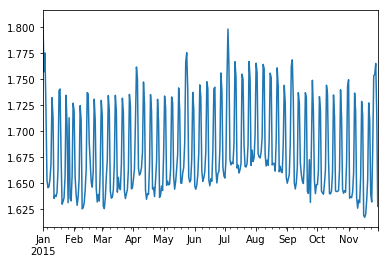

In [27]:
# let's plot the passenger counts by day. this is very efficient with our index.
(df3.passenger_count
       .resample('1d')
       .mean()
       .compute()
       .plot())

In [ ]:
# good periodicity; higher passenger counts on the weekend days